In [1]:
from scipy.stats import f_oneway
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmath 
import seaborn as sns

from sklearn.impute import SimpleImputer
import os

In [2]:
# Import some additional libraries for ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def split_cell(df):
    df_charge = df[df['type'] == 'charge']
    df_discharge = df[df['type'] == 'discharge']
    df_impedance = df[df['type'] == 'impedance']

    df_charge = df_charge.reset_index(drop=True)  # Drops old index, new one is not saved in CSV
    df_discharge = df_discharge.reset_index(drop=True)
    df_impedance = df_impedance.reset_index(drop=True)
    
    return df_charge,df_discharge,df_impedance

In [4]:
def expand(charge,discharge):
    df_charge = charge.join(pd.json_normalize(charge['data']))
    df_discharge = discharge.join(pd.json_normalize(discharge['data']))

    df_charge["cycle"] = range(1, len(df_charge) + 1)
    df_discharge["cycle"] = range(1, len(df_discharge) + 1)
    
    # Drop the original 'data' column as it's no longer needed
    df_charge.drop(columns=['data'], inplace=True)
    df_discharge.drop(columns=['data'], inplace=True)
    return df_charge,df_discharge

In [5]:
def process_charge_data(df_charge):
    df_charge_processed = df_charge.copy()
    
    # List of features that contain array
    array_features = [
        "Voltage_measured", "Current_measured", "Temperature_measured",
        "Current_charge", "Voltage_charge"
    ]
    
    for feature in array_features:
        df_charge_processed[feature] = df_charge_processed[feature].apply(np.mean)

    return df_charge_processed

In [6]:
def process_discharge_data(df_discharge):
    df_discharge_processed = df_discharge.copy()
    
    # List of features that contain arrays
    array_features = [
        "Voltage_measured", "Current_measured", "Temperature_measured",
        "Current_load", "Voltage_load"
    ]
    
    for feature in array_features:
        df_discharge_processed[feature] = df_discharge_processed[feature].apply(np.mean)
    
    df_discharge_processed["Capacity"] = df_discharge_processed["Capacity"]

    return df_discharge_processed

In [7]:
def preprocess_data(df):
    charge,discharge,_=split_cell(df)
    charge,discharge=expand(charge,discharge)
    
    df_charge_processed = process_charge_data(charge)
    df_discharge_processed = process_discharge_data(discharge)    

    return df_charge_processed,df_discharge_processed

def merge_cycles(charge,discharge):
    # Merge on cycle number
    df_merged = pd.merge(charge, discharge, on="cycle", how="inner")
    return df_merged

In [8]:
def merge_cycles(charge, discharge):
    # Merge on both battery_id_x and cycle to ensure proper alignment
    df_merged = pd.merge(charge, discharge, on=["battery_id", "cycle"], how="inner")
    return df_merged


In [9]:
import os
import pickle
import pandas as pd

processed_dfs = []

data_folder = "../Dataset/data"
selected_files = ['B0005.pkl', 'B0006.pkl', 'B0007.pkl', 'B0018.pkl']

for filename in selected_files:
    battery_id = filename.split(".")[0]
    file_path = os.path.join(data_folder, filename)
    
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            battery_raw_data = pickle.load(f)

        # Preprocess
        df_charge, df_discharge = preprocess_data(battery_raw_data)

        # Add battery_id
        df_charge["battery_id"] = battery_id
        df_discharge["battery_id"] = battery_id

        # Add cycle number using range
        df_charge["cycle"] = list(range(1, len(df_charge) + 1))
        df_discharge["cycle"] = list(range(1, len(df_discharge) + 1))

        # ✅ Merge charge and discharge data on battery_id and cycle
        df_processed = pd.merge(df_charge, df_discharge, on=["battery_id", "cycle"], suffixes=("_charge", "_discharge"))

        processed_dfs.append(df_processed)

# Final merged DataFrame
df = pd.concat(processed_dfs, ignore_index=True)


In [10]:
print('Features in DataFrame')
for i in df.columns:
    print(f"->{i}")
print()

Features in DataFrame
->type_charge
->ambient_temperature_charge
->time_charge
->Voltage_measured_charge
->Current_measured_charge
->Temperature_measured_charge
->Current_charge
->Voltage_charge
->Time_charge
->cycle
->battery_id
->type_discharge
->ambient_temperature_discharge
->time_discharge
->Voltage_measured_discharge
->Current_measured_discharge
->Temperature_measured_discharge
->Current_load
->Voltage_load
->Time_discharge
->Capacity



In [11]:
df.tail()

,type_charge,ambient_temperature_charge,time_charge,Voltage_measured_charge,Current_measured_charge,Temperature_measured_charge,Current_charge,Voltage_charge,Time_charge,cycle,...,type_discharge,ambient_temperature_discharge,time_discharge,Voltage_measured_discharge,Current_measured_discharge,Temperature_measured_discharge,Current_load,Voltage_load,Time_discharge,Capacity
631,charge,24,3608061.609,4.170361,0.483208,24.147820,0.479199,4.406275,"[0.0, 2.516000000000002, 9.329, 15.985, 22.688...",128,...,discharge,24,3644885.984,3.455229,-1.782780,31.818465,1.773505,2.285750,"[0.0, 9.311999999999998, 23.671999999999997, 3...",1.362737
632,charge,24,3621668.421,4.161601,0.508179,25.127355,0.504328,4.409525,"[0.0, 2.484000000000001, 9.281000000000002, 15...",129,...,discharge,24,3657934.718,3.461974,-1.772521,32.000672,1.763543,2.276868,"[0.0, 9.328000000000003, 23.813000000000002, 3...",1.363405
633,charge,24,3634720.828,4.160779,0.506123,25.659479,0.502350,4.232179,"[0.0, 2.4540000000000006, 9.282000000000004, 1...",130,...,discharge,24,3672979.656,3.452222,-1.769870,31.739922,1.761211,2.262391,"[0.0, 9.311999999999998, 23.765, 37.406, 51.09...",1.351865
634,charge,24,3647761.734,4.161272,0.505389,26.045549,0.501652,4.408166,"[0.0, 2.4530000000000003, 9.391, 16.141, 22.85...",131,...,discharge,24,3688514.546,3.447650,-1.788485,31.526136,1.779889,2.286657,"[0.0, 9.359000000000002, 23.844, 37.562, 51.31...",1.354797
635,charge,24,3660813.906,4.160758,0.507932,26.002153,0.504004,4.111653,"[0.0, 2.452999999999996, 9.421999999999997, 16...",132,...,discharge,24,3701433.765,3.447929,-1.777740,31.276245,1.768835,2.269965,"[0.0, 9.296, 23.843000000000004, 37.593, 51.29...",1.341051


In [12]:
columns_to_drop = [
    "type_charge", "type_discharge", "time_charge", "time_discharge", "Time_charge", "Time_discharge",
    "ambient_temperature_charge", "ambient_temperature_discharge"
]

df = df.drop(columns=columns_to_drop)

In [13]:
df.tail()

,Voltage_measured_charge,Current_measured_charge,Temperature_measured_charge,Current_charge,Voltage_charge,cycle,battery_id,Voltage_measured_discharge,Current_measured_discharge,Temperature_measured_discharge,Current_load,Voltage_load,Capacity
631,4.170361,0.483208,24.147820,0.479199,4.406275,128,B0018,3.455229,-1.782780,31.818465,1.773505,2.285750,1.362737
632,4.161601,0.508179,25.127355,0.504328,4.409525,129,B0018,3.461974,-1.772521,32.000672,1.763543,2.276868,1.363405
633,4.160779,0.506123,25.659479,0.502350,4.232179,130,B0018,3.452222,-1.769870,31.739922,1.761211,2.262391,1.351865
634,4.161272,0.505389,26.045549,0.501652,4.408166,131,B0018,3.447650,-1.788485,31.526136,1.779889,2.286657,1.354797
635,4.160758,0.507932,26.002153,0.504004,4.111653,132,B0018,3.447929,-1.777740,31.276245,1.768835,2.269965,1.341051


In [14]:
def plot_capacity_over_cycles(df, battery_ids):
    plt.figure(figsize=(12, 8))
    
    for i in range(len(battery_ids)):
        battery_data = df[df['battery_id'] == battery_ids[i]]
        plt.subplot(2,2,i+1)
        plt.plot(battery_data['cycle'], battery_data['Capacity'],label=f"Battery {battery_ids[i]}")
        plt.xlabel("Cycle")
        plt.ylabel("Capacity")
        plt.title("Capacity vs Cycle for Different Batteries")
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

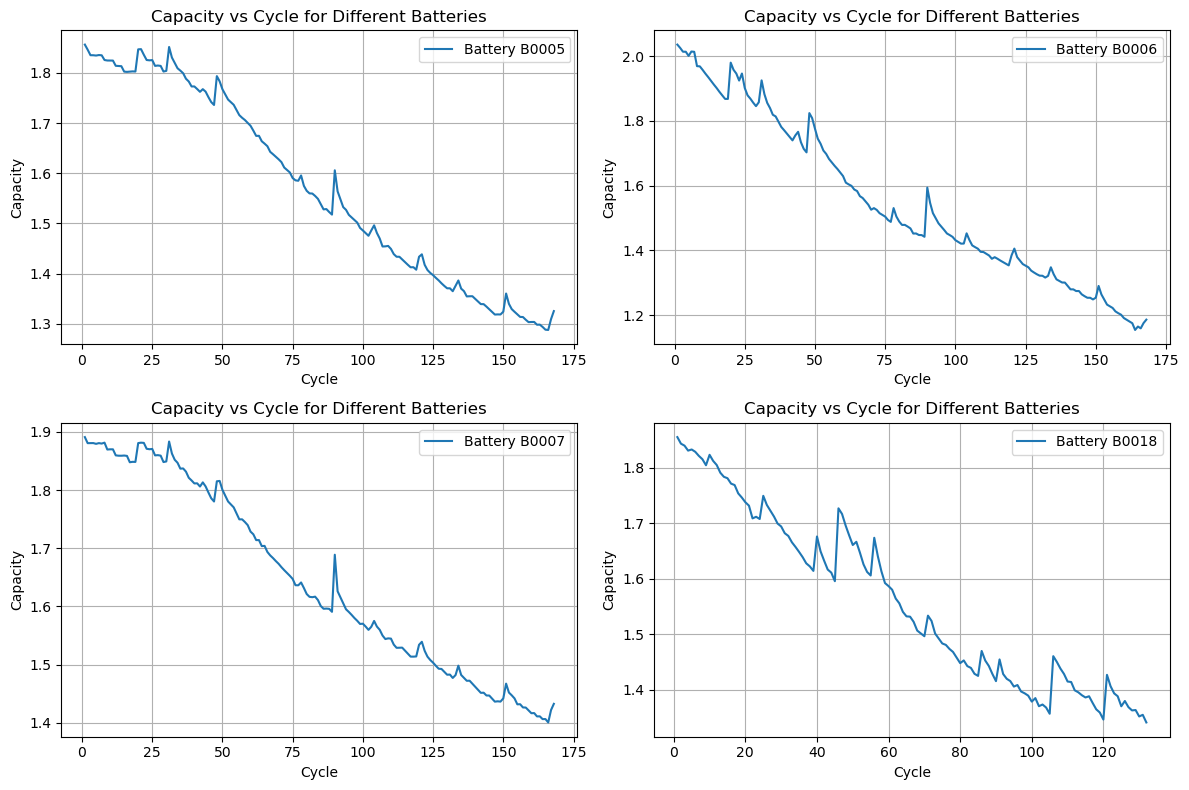

In [15]:
battery_ids = ['B0005', 'B0006', 'B0007', 'B0018']
plot_capacity_over_cycles(df, battery_ids)

In [16]:
import numpy as np
import pandas as pd

def fix_capacity(val):
    if isinstance(val, np.ndarray):
        return val.item() if val.size == 1 else np.nan  # get scalar if 1-element array
    elif isinstance(val, (float, int)):
        return val
    else:
        return np.nan

df["Capacity"] = df["Capacity"].apply(fix_capacity)

In [17]:
df=df.dropna()

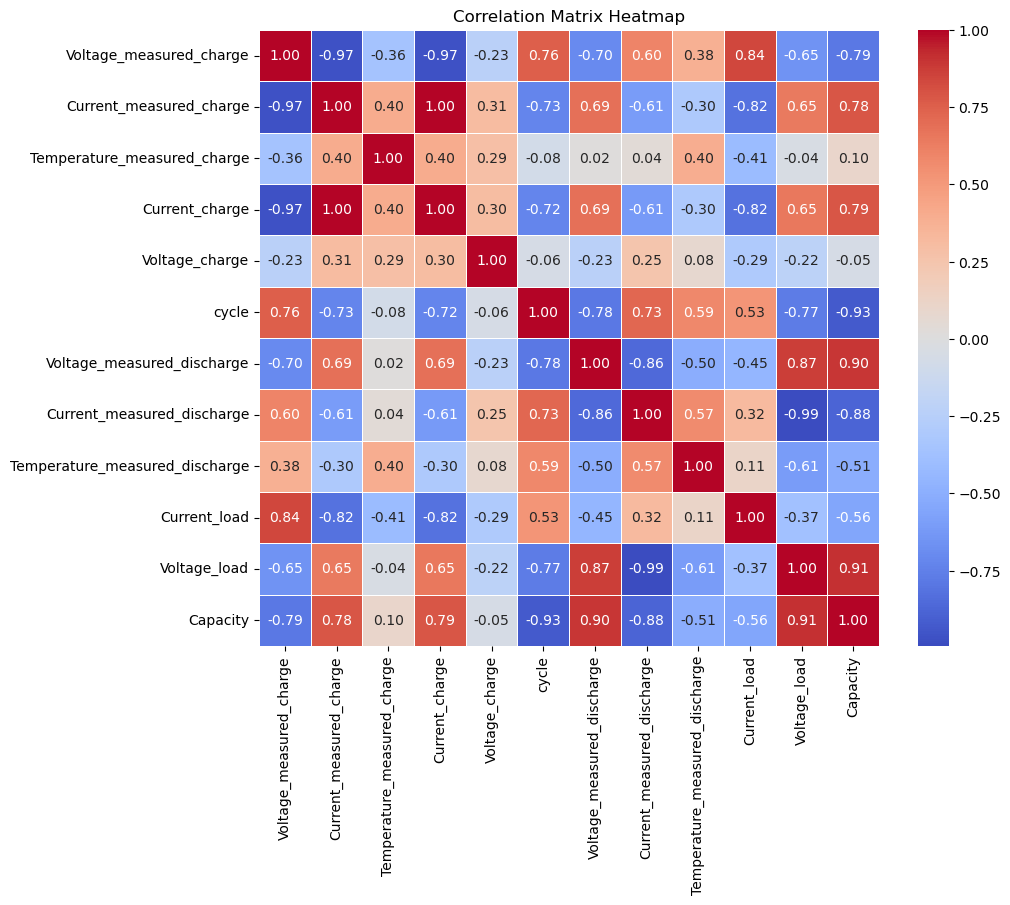

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
df1=df.drop(['battery_id'],axis=1)
corr_matrix = df1.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [19]:
df1.isnull().sum()

Voltage_measured_charge           0
Current_measured_charge           0
Temperature_measured_charge       0
Current_charge                    0
Voltage_charge                    0
cycle                             0
Voltage_measured_discharge        0
Current_measured_discharge        0
Temperature_measured_discharge    0
Current_load                      0
Voltage_load                      0
Capacity                          0
dtype: int64

In [20]:
features = df.drop(columns=["cycle", "Capacity",'battery_id'])  
target = df["Capacity"]

In [21]:
print(len(features),len(target))

635 635


In [22]:
imputer = SimpleImputer(strategy='mean')
features= imputer.fit_transform(features)

In [23]:
print(len(features),len(target))

635 635


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Select relevant features


# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [25]:
# Train Random Forest Model with best params
model = RandomForestRegressor(n_estimators=400, max_depth=30, min_samples_split=2, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mse=mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0004
Mean Absolute Error (MAE): 0.0128
R-squared (R²): 0.9896


In [26]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
# Scale the imputed data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create and train SVR model
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svr_model.predict(X_test_scaled)

# Evaluate SVR model performance
mse=mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 0.0030
Mean Absolute Error (MAE): 0.0465
R-squared (R²): 0.9213


In [27]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Set up hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

# Step 3: Initialize GridSearchCV with SVR
grid_search = GridSearchCV(
    SVR(kernel='rbf'),
    param_grid,
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Step 4: Fit the model
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 0.2, 0.5],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1]},
             scoring='r2', verbose=1)

In [28]:
# Step 5: Predict and evaluate
best_svr = grid_search.best_estimator_
svr_preds = best_svr.predict(X_test_scaled)
svr_r2 = r2_score(y_test, svr_preds)
svr_mse = mean_squared_error(y_test, svr_preds)

print("Best Parameters:", grid_search.best_params_)
print(f"SVR R² Score: {svr_r2:.3f}")
print(f"SVR Mean Squared Error: {svr_mse:.4f}")

Best Parameters: {'C': 10, 'epsilon': 0.01, 'gamma': 'scale'}
SVR R² Score: 0.989
SVR Mean Squared Error: 0.0004


In [29]:
target

0      1.856487
1      1.846327
2      1.835349
3      1.835263
4      1.834646
         ...   
631    1.362737
632    1.363405
633    1.351865
634    1.354797
635    1.341051
Name: Capacity, Length: 635, dtype: float64

In [30]:
rf_pred=model.predict(features)

In [31]:
len(rf_pred)

635

In [56]:
def plot_predicted_vs_actual(df_merged, pred, battery_ids):
    plt.figure(figsize=(12, 8))
    
    for i in range(len(battery_ids)):
        battery_data = df_merged[df_merged['battery_id'] == battery_ids[i]]
        battery_pred = pred[df_merged['battery_id'] == battery_ids[i]]

        plt.subplot(2, 2, i + 1)
        plt.plot(battery_data['cycle'], battery_data['Capacity'], color='blue', label='Actual Capacity')
        plt.plot(battery_data['cycle'], battery_pred, color='red', label='Predicted Capacity')
        plt.xlabel("Cycle")
        plt.ylabel("Capacity")
        plt.title(f"Battery {battery_ids[i]}")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


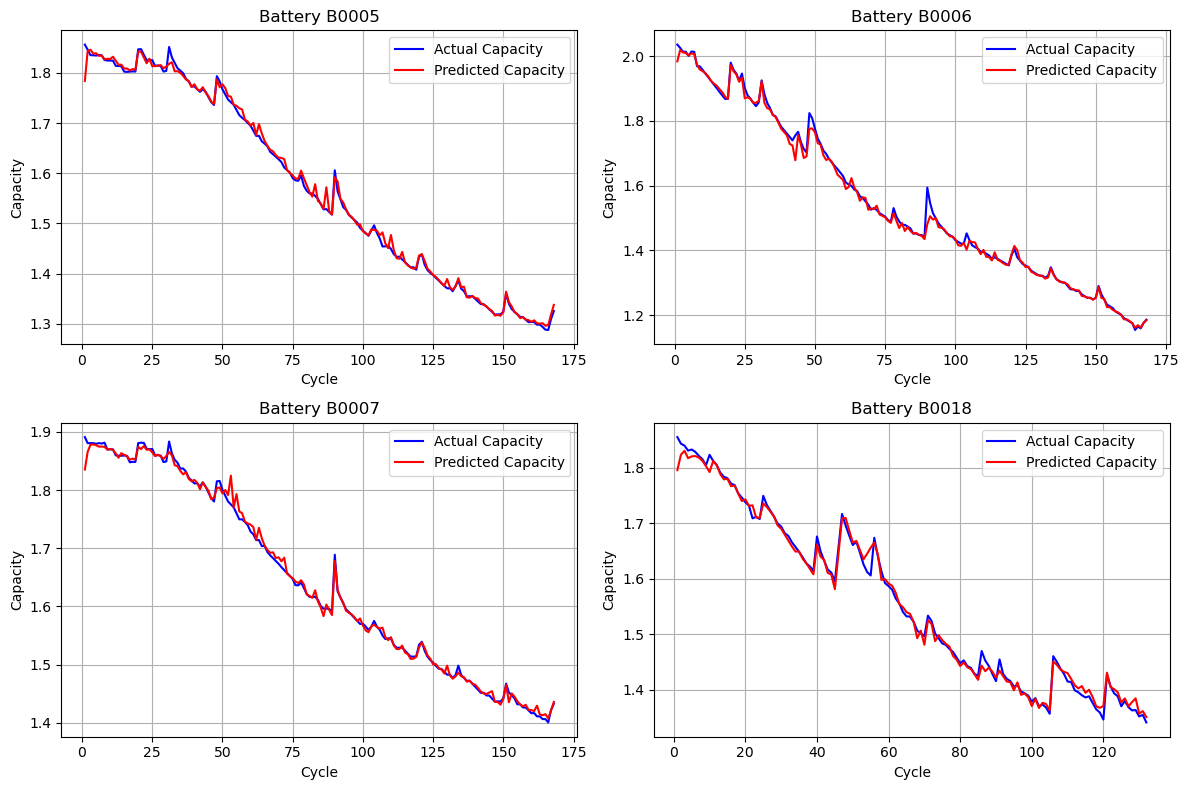

In [57]:
plot_predicted_vs_actual(df,rf_pred,battery_ids)

In [44]:
X=scaler.transform(features)
svr_pred=best_svr.predict(X)

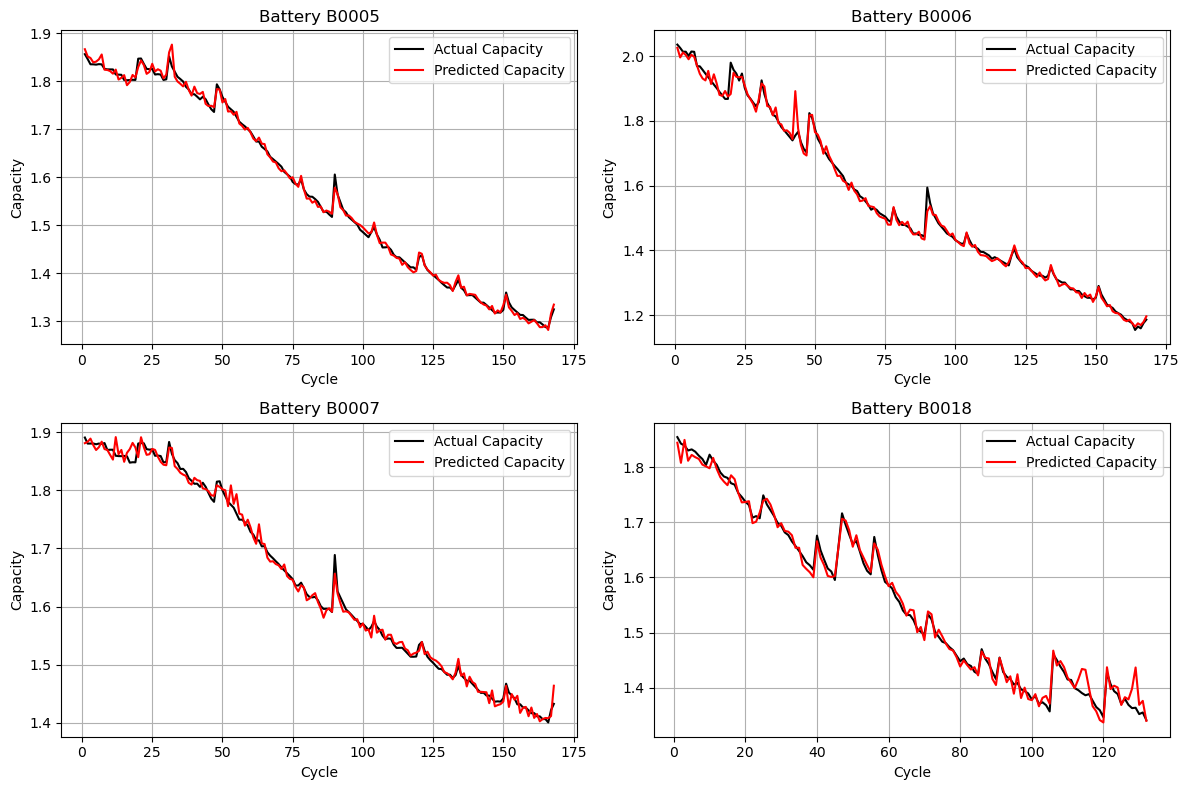

In [35]:
plot_predicted_vs_actual(df,svr_pred,battery_ids)

In [36]:
def plot_predicted_vs_actual_of(df_merged, pred1,pred2, battery_ids):
    plt.figure(figsize=(12, 8))
    
    for i in range(len(battery_ids)):
        battery_data = df_merged[df_merged['battery_id'] == battery_ids[i]]
        pred_1 = pred1[df_merged['battery_id'] == battery_ids[i]]
        pred_2 = pred2[df_merged['battery_id'] == battery_ids[i]]
        
        plt.subplot(2, 2, i + 1)
        plt.plot(battery_data['cycle'], battery_data['Capacity'], color='black', label='Actual Capacity')
        plt.plot(battery_data['cycle'], pred_1, color='red', label='rf Predicted Capacity',alpha=0.5)
        plt.plot(battery_data['cycle'], pred_2, color='blue', label='svr Predicted Capacity',alpha=0.5)
        plt.xlabel("Cycle")
        plt.ylabel("Capacity")
        plt.title(f"Battery {battery_ids[i]}")
        plt.legend()
        plt.grid(False)

    plt.tight_layout()
    plt.show()

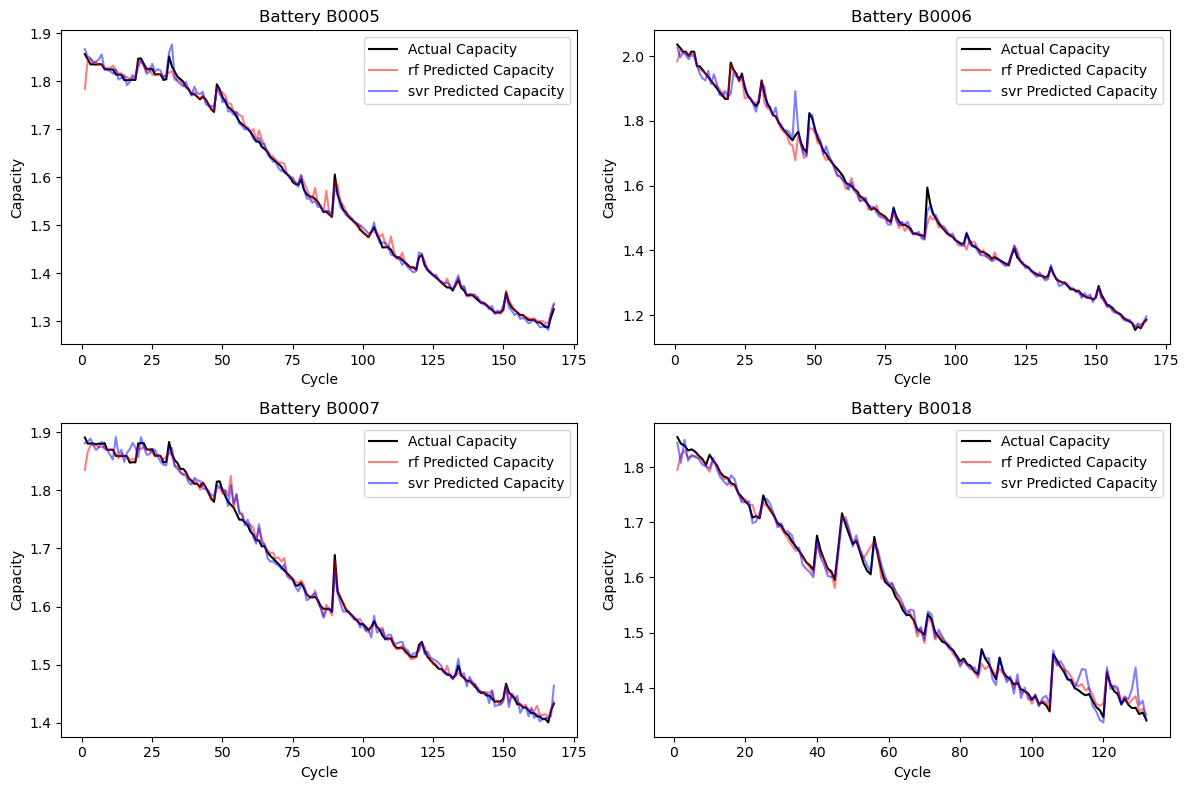

In [37]:
plot_predicted_vs_actual_of(df,rf_pred,svr_pred,battery_ids)

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Define all models
models = {
    'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
    'Support Vector Regression': make_pipeline(StandardScaler(), SVR(C= 10,epsilon= 0.01,gamma= 'scale')),
    'Decision Tree Regression': DecisionTreeRegressor(random_state=42),
    'Random Forest Regression': RandomForestRegressor(n_estimators=400, max_depth=30, min_samples_split=2, random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost Regression': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
}

In [39]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'

In [40]:
# Train, evaluate and predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Store results in a list of dicts
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "R2": r2,
        "MAE": mae,
        "MSE": mse
    })

# Sort by R² Score ascending (change to 'MAE' or 'MSE' if you prefer)
sorted_results = sorted(results, key=lambda x: x["R2"],reverse=True)

In [41]:
# Print results
# Nicely aligned output
print(f"\n{bcolors.BOLD}{'Model':<30} {'R² Score':<15} {'MAE':<15} {'MSE':<15}{bcolors.ENDC}")
print(f"{'-'*70}")

for res in sorted_results:
    print(f"{bcolors.HEADER}{res['Model']:<30}{bcolors.ENDC}"
          f"{bcolors.OKGREEN}{res['R2']:<15.5f}{bcolors.ENDC}"
          f"{bcolors.OKBLUE}{res['MAE']:<15.5f}{bcolors.ENDC}"
          f"{bcolors.OKCYAN}{res['MSE']:<15.5f}{bcolors.ENDC}")


Model                          R² Score        MAE             MSE            
----------------------------------------------------------------------
XGBoost Regression            0.99243        0.01179        0.00029        
Random Forest Regression      0.98962        0.01279        0.00039        
Support Vector Regression     0.98881        0.01249        0.00042        
Gradient Boosting Regression  0.98877        0.01489        0.00042        
Decision Tree Regression      0.98331        0.01690        0.00063        
Linear Regression             0.93779        0.04075        0.00234        
